# Model for AFM Image Coverage By Fine-tuning Resnet18 Pretrained on MicroNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import *
from matplotlib import  style


import time
import os
import copy
import random


import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset

import json
import pickle


import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error as mse

from timeit import default_timer as timer



from codes.utils_coverage import CustomImageDataset, grouped_train_test_split, model_inference, coverage_models_inference



torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
batch_size = 100

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
print(torch.cuda.mem_get_info(device=None))

(25055854592, 25438126080)


In [2]:
with open("Data/WSe2_sample_labels", "rb") as fp:   #Pickling
   data_sample_labels = pickle.load(fp)


train_group = data_sample_labels['train']
val_group = data_sample_labels['val']
test_group = data_sample_labels['test']

In [5]:
# Specify the path to your dataset folder
# root_dir = 'patches_2023-09-14'
#root_dir = '/noether/s0/wfr5091/wse2/2023-09-15_n5'
root_dir = 'Data/WSe2_micrographs'


transform_test = transforms.Compose([
      #transforms.ToPILImage(),

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])

batch_size = 32
def data_feeder(batch_size):
    transform = transforms.Compose([
      #transforms.ToPILImage(),
      transforms.RandomRotation(degrees= (0, 180)),
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomVerticalFlip(0.5),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])
   
    custom_dataset = CustomImageDataset(root_dir, transform=transform, max_index=None)

    train_dataset, val_dataset, test_dataset = grouped_train_test_split(train_group, val_group, test_group,custom_dataset, test_size=0.1, random_state=0)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return train_dataloader, val_dataloader, test_dataloader

In [6]:


model_micro = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
#url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'microscopynet')
url = pmm.util.get_pretrained_microscopynet_url('resnet18', 'micronet')
map_location=torch.device('cpu')
model_micro.load_state_dict(model_zoo.load_url(url))
#model_micro.eval()  # <- MicrosNet model for 


Using cache found in /home/faculty/iam5249/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [7]:
model_micro.fc = nn.Sequential(#nn.ReLU(),
                             #nn.Dropout(p=0.25), #0.65 for the saved model
                                nn.Linear(512, 100), #150, 1
                                 nn.ReLU(),
                                
                                 nn.Dropout(p=0.25),
                                 nn.Linear(100, 1),
                                nn.Sigmoid()
                                 )
model_micro.to(device)
#print(model_micro)

input = torch.randn(16, 3, 224, 224).to(device)
input.to(device)
#print(input.shape)
output = model_micro(input)
output.shape

#model_micro.eval()



torch.Size([16, 1])

In [8]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#mae = nn.L1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_micro.parameters(), lr=0.0000225)#, 0.000225weight_decay = 0.0001) # 0.005 was used in the saved model I 

In [9]:

start = timer()


running_loss_list = []
val_running_loss_list = []
mean_abs_error_list = []
val_mean_abs_error_list = []


performance_record = {'train': {'loss': [], 'mae': []}, 'val': {'val_loss': [], 'val_mae': []}}
for epoch in range(1, 4500):  # loop over the dataset multiple times  3001th
    train_dataloader, val_dataloader, test_dataloader = data_feeder(batch_size)    
    true_train = []
    pred_train = []

    true_val = []
    pred_val = []    
  
    #model_micro.train()
    for inputs, labels, groups in train_dataloader:
    
        
        inputs, labels = inputs.float().to(device), labels.float().unsqueeze(1).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward  + optimize

        outputs = model_micro(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        true_train += labels.cpu().tolist()
        pred_train += outputs.cpu().tolist()
      


    #model_micro.eval()
    with torch.no_grad():
        for inputs, labels, groups in val_dataloader:

            inputs, labels = inputs.float().to(device), labels.float().unsqueeze(1).to(device)
            outputs = model_micro(inputs)
            val_loss = criterion(outputs, labels)

            true_val += labels.cpu().tolist()
            pred_val += outputs.cpu().tolist()

    train_mae = mae(true_train, pred_train)
    train_rmse = np.sqrt(mse(true_train,pred_train))
    
    val_mae = mae(true_val, pred_val)
    val_rmse = np.sqrt(mse(true_val,pred_val))
    
    
      
    running_loss_list.append(float(f'{train_rmse:.4f}'))
    val_running_loss_list.append(float(f'{val_rmse:.4f}'))
    mean_abs_error_list.append(float(f'{train_mae:.4f}'))
    val_mean_abs_error_list.append(float(f'{val_mae:.4f}'))
    print(f'Epoch{epoch}: rmse: {train_rmse:.4f} val_rmse: {val_rmse :.4f}, mae: {train_mae:.4f} val_mae: {val_mae:.4f}')
    
    if train_mae <= 0.030 and val_mae <= 0.020:#0.028 achieved
        break
performance_record['train']['loss'] += running_loss_list
performance_record['train']['mae'] += mean_abs_error_list
performance_record['val']['val_loss'] += val_running_loss_list
performance_record['val']['val_mae']  += val_mean_abs_error_list

end = timer()
print((end - start)/3600)


Epoch1: rmse: 0.2696 val_rmse: 0.1967, mae: 0.2350 val_mae: 0.1584
Epoch2: rmse: 0.1719 val_rmse: 0.1439, mae: 0.1324 val_mae: 0.1010
Epoch3: rmse: 0.1522 val_rmse: 0.1385, mae: 0.1116 val_mae: 0.1016
Epoch4: rmse: 0.1321 val_rmse: 0.1303, mae: 0.0936 val_mae: 0.0892
Epoch5: rmse: 0.1193 val_rmse: 0.1203, mae: 0.0875 val_mae: 0.0871
Epoch6: rmse: 0.1093 val_rmse: 0.1180, mae: 0.0787 val_mae: 0.0823
Epoch7: rmse: 0.1049 val_rmse: 0.1139, mae: 0.0761 val_mae: 0.0815
Epoch8: rmse: 0.1060 val_rmse: 0.1169, mae: 0.0756 val_mae: 0.0848
Epoch9: rmse: 0.0961 val_rmse: 0.1211, mae: 0.0705 val_mae: 0.0810
Epoch10: rmse: 0.1031 val_rmse: 0.1090, mae: 0.0710 val_mae: 0.0802
Epoch11: rmse: 0.1011 val_rmse: 0.1095, mae: 0.0688 val_mae: 0.0766
Epoch12: rmse: 0.1006 val_rmse: 0.1098, mae: 0.0701 val_mae: 0.0798
Epoch13: rmse: 0.0885 val_rmse: 0.1152, mae: 0.0632 val_mae: 0.0759
Epoch14: rmse: 0.0913 val_rmse: 0.1034, mae: 0.0638 val_mae: 0.0757
Epoch15: rmse: 0.0865 val_rmse: 0.1147, mae: 0.0619 val_m

In [20]:
with open("Models/performance_Micro_sample", "wb") as fp:   #Pickling
  pickle.dump(performance_record, fp)
  
# to save model
PATH = 'Models/model_Micro_sample.pth'
torch.save(model_micro.state_dict(), PATH)


In [8]:
# specify path
PATH = "Models/model_Micro_sample.pth"
# to load model

#model = model_micro()
model_micro.load_state_dict(torch.load(PATH))
model_micro.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
with open("Models/performance_Micro_sample", "rb") as fp:   #Pickling
   performance_record = pickle.load(fp)

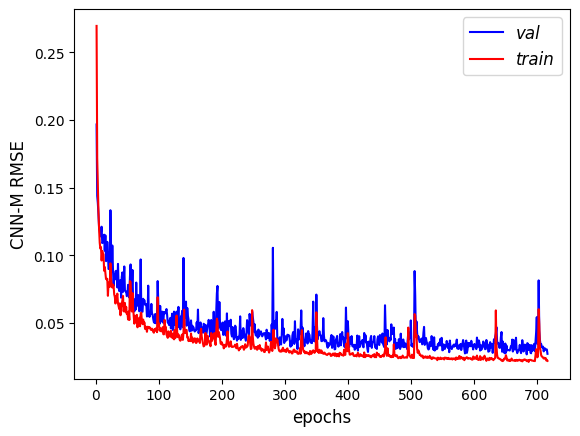

In [9]:
#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

history_dict = performance_record
loss_values = history_dict['train']['loss']
val_loss_values = history_dict['val']['val_loss']

acc_values = history_dict['train']['mae']
val_acc_values = history_dict['val']['val_mae']
epochs = range(1, len(acc_values) + 1)
N = 200



fig, ax1 = plt.subplots()
rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.style'] = 'italic'
plt.xlabel('epochs', size=12)
plt.ylabel('CNN-M RMSE', size=12)

#plt.style.use("bmh")

#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})


left, bottom, width, height = [0.39, 0.55, 0.5, 0.32]


ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, 'b', label = 'val')
ax1.plot(range(1, len(loss_values) + 1), loss_values, 'r', label = 'train')


#ax1.grid(axis='y')


plt.legend()

plt.savefig("Results/IM_Micro_coverage_RMSE_sampple.png", dpi=600)
plt.show()

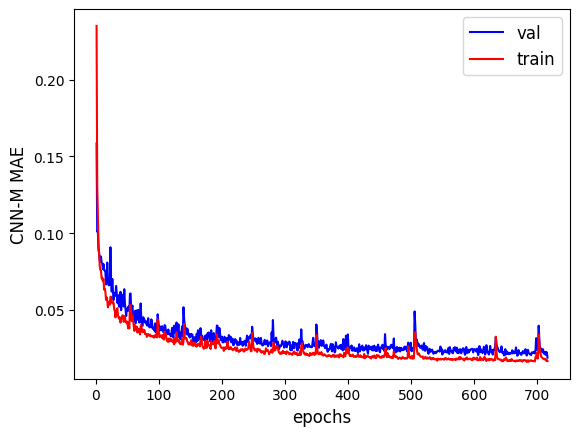

In [12]:

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

history_dict = performance_record
loss_values = history_dict['train']['loss']
val_loss_values = history_dict['val']['val_loss']

acc_values = history_dict['train']['mae']
val_acc_values = history_dict['val']['val_mae']
epochs = range(1, len(acc_values) + 1)
N = 200



fig, ax1 = plt.subplots()
rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'
#plt.rcParams['font.style'] = 'italic'
plt.xlabel('epochs', size=12)
plt.ylabel('CNN-M MAE', size=12)

#plt.style.use("bmh")

#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})

left, bottom, width, height = [0.39, 0.55, 0.5, 0.32]

ax1.plot(range(1, len(val_loss_values) + 1), val_acc_values, 'b', label = 'val')
ax1.plot(range(1, len(loss_values) + 1), acc_values, 'r', label = 'train')



#ax1.grid(axis='y')

plt.legend()

plt.savefig("Results/IM_Micro_coverage_mae_sampple.png", dpi=600)
plt.show()

In [13]:
def data_feeder(batch_size):
    transform = transforms.Compose([

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])

#data augmentation


   
    custom_dataset = CustomImageDataset(root_dir, transform=transform, max_index=None)
   
    train_dataset, val_dataset, test_dataset = grouped_train_test_split(train_group, val_group, test_group,custom_dataset, test_size=0.1, random_state=0)

  
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = data_feeder(batch_size)

len of groups:  2210
len of unique groups:  52


In [15]:
model = model_micro
true_test, pred_test, test_mae, test_rmse = model_inference(model, test_dataloader)
true_val, pred_val, val_mae, val_rmse = model_inference(model, val_dataloader)
true_train, pred_train, train_mae, train_rmse = model_inference(model, train_dataloader)

print(test_mae)
print(test_rmse)

print(val_mae)
print(val_rmse)

print(train_mae)
print(train_rmse)

0.025000012051516578
0.035461189810244015
0.017427273384736958
0.022923133333725386
0.01778192741050699
0.02345522487034425


In [16]:
test_r2_score = r2_score(true_test, pred_test)
val_r2_score = r2_score(true_val, pred_val)
train_r2_score = r2_score(true_train, pred_train)

print('train: ', train_r2_score, 'val: ', val_r2_score, 'test: ', test_r2_score)

train:  0.9944988334576751 val:  0.9946359401009628 test:  0.9843662955389941


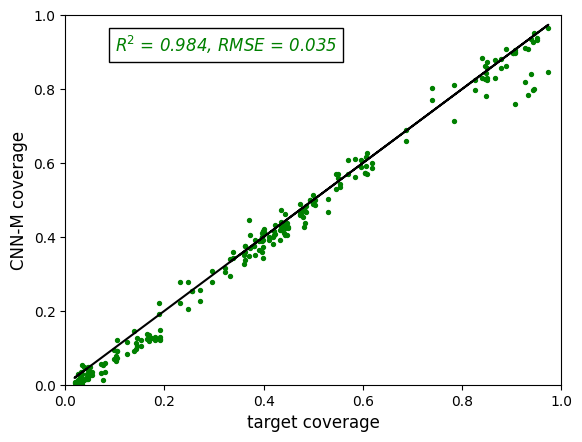

In [17]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

test_r2_score = r2_score(true_test, pred_test)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNN-M coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {test_r2_score:.3f}, RMSE = {test_rmse:.3f}', style='italic', color = 'g', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_test, pred_test, color = 'g', s=8)

plt.plot(true_test, true_test, 'black')

plt.savefig("Results/IM_Micro_coverage_test_sample.png", dpi=600)
plt.savefig("Results/IM_Micro_coverage_test_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


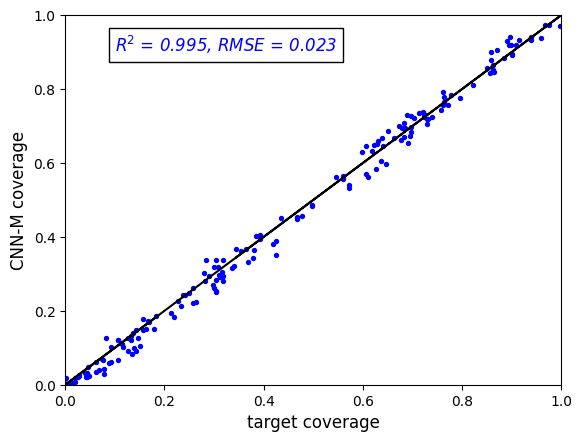

In [18]:
#Val

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

val_r2_score = r2_score(true_val, pred_val)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNN-M coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {val_r2_score:.3f}, RMSE = {val_rmse:.3f}', style='italic', color = 'b', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_val, pred_val, color = 'b', s=8)

plt.plot(true_val, true_val, 'black')

plt.savefig("Results/IM_Micro_coverage_val_sample.png", dpi=600)
plt.savefig("Results/IM_Micro_coverage_val_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


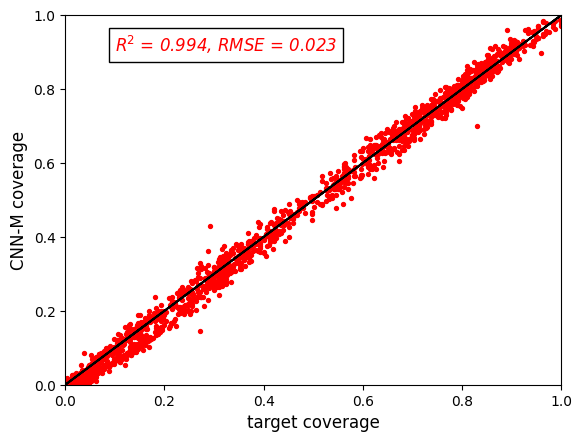

In [19]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

train_r2_score = r2_score(true_train, pred_train)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNN-M coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {train_r2_score:.3f}, RMSE = {train_rmse:.3f}', style='italic', color = 'r', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_train, pred_train, color = 'r', s=8)

plt.plot(true_train, true_train, 'black')

plt.savefig("Results/IM_Micro_coverage_train_sample.png", dpi=600)
plt.savefig("Results/IM_Micro_coverage_train_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


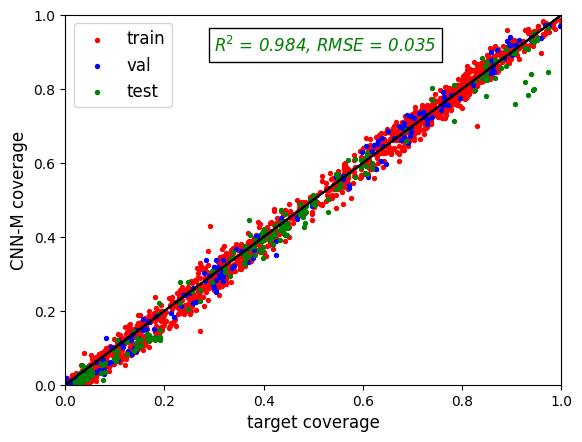

In [21]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

fig, ax1 = plt.subplots()

#rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'


train_r2_score = r2_score(true_train, pred_train)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNN-M coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.3
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {test_r2_score:.3f}, RMSE = {test_rmse:.3f}', style='italic', color = 'g', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


ax1.scatter(true_train, pred_train, color = 'r', s=8, label='train')
ax1.scatter(true_val, pred_val, color = 'b', s=8, label='val')
ax1.scatter(true_test, pred_test, color = 'g', s=8, label='test')
ax1.plot(true_train, true_train, 'black')
plt.legend()
plt.savefig("Results/IM_Micro_coverage_train_val_test_sample.png", dpi=600)
plt.savefig("Results/IM_Micro_coverage_train_val_test_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Inference on whole Images

In [9]:


# Specify the path to your dataset folder
# root_dir = 'patches_2023-09-14'
#root_dir = '/noether/s0/wfr5091/wse2/2023-09-15_n5'
root_dir = 'Data/WSe2_2023-11-30_coverage_whole' #'Data/2023-10-21_full'


transform_test = transforms.Compose([
      #transforms.ToPILImage(),

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])

batch_size = 1
def data_feeder(batch_size):
    transform = transforms.Compose([

      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])

#data augmentation


   
    custom_dataset = CustomImageDataset(root_dir, transform=transform, max_index=None)
   
    train_dataset, val_dataset, test_dataset = grouped_train_test_split(train_group, val_group, test_group,custom_dataset, test_size=0.1, random_state=0)

  
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = data_feeder(batch_size)

len of groups:  221
len of unique groups:  52


In [11]:
# Test Images
true_label = []
pred_label = []
j = 1
for inputs, labels, groups in test_dataloader:
    
    pred = coverage_models_inference(inputs, model_micro)
    true_label.append(labels.numpy()[0])
    pred_label.append(pred)
    print(j, 'pred: ', pred, 'label: ', labels.numpy()[0])
    j += 1

1 pred:  0.04784589260816574 label:  0.03886
2 pred:  0.04017419040203094 label:  0.04347
3 pred:  0.045306154526770115 label:  0.04795
4 pred:  0.014638725792368253 label:  0.03568
5 pred:  0.08448022877176603 label:  0.09856
6 pred:  0.12045933339330885 label:  0.17624
7 pred:  0.1133577639857928 label:  0.15027
8 pred:  0.4218568796912829 label:  0.44557
9 pred:  0.47045071721076964 label:  0.45203
10 pred:  0.40093355708652073 label:  0.40867
11 pred:  0.3969527320729362 label:  0.42824
12 pred:  0.3249163175340403 label:  0.36275
13 pred:  0.36225499559871177 label:  0.39012
14 pred:  0.3620107378641313 label:  0.39576
15 pred:  0.39015945728698914 label:  0.42281
16 pred:  0.7795347694138234 label:  0.84834
17 pred:  0.8005897754125975 label:  0.86533
18 pred:  0.708420960821042 label:  0.90927
19 pred:  0.7608414065685462 label:  0.92974
20 pred:  0.6028789122899373 label:  0.5707
21 pred:  0.4818632543087006 label:  0.45093
22 pred:  0.4471532901128133 label:  0.44771
23 pred: 

In [13]:

# list of name, degree, score
     
# dictionary of lists
Micro_cov = pred_label
label = true_label
sample = [i for i in range(1, 24)]

dict = {'sample': sample, 'label': label, 'Micro_cov': Micro_cov}
     
df = pd.DataFrame(dict)
     
# saving the dataframe
myfile = 'Results/Micro_cov.csv'
df.to_csv(myfile)

In [12]:
# Test Images
true_label = []
pred_label = []
j = 1
for inputs, labels, groups in test_dataloader:
    
    pred = coverage_models_inference(inputs, model_micro)
    true_label.append(labels.numpy()[0])
    pred_label.append(pred)
    print(j, 'pred: ', pred, 'label: ', labels.numpy())
    j += 1

1 pred:  0.04784589260816574 label:  [0.03886]
2 pred:  0.04017419040203094 label:  [0.04347]
3 pred:  0.045306154526770115 label:  [0.04795]
4 pred:  0.014638725792368253 label:  [0.03568]
5 pred:  0.08448022877176603 label:  [0.09856]
6 pred:  0.12045933339330885 label:  [0.17624]
7 pred:  0.1133577639857928 label:  [0.15027]
8 pred:  0.4218568796912829 label:  [0.44557]
9 pred:  0.47045071721076964 label:  [0.45203]
10 pred:  0.40093355708652073 label:  [0.40867]
11 pred:  0.3969527320729362 label:  [0.42824]
12 pred:  0.3249163175340403 label:  [0.36275]
13 pred:  0.36225499559871177 label:  [0.39012]
14 pred:  0.3620107378641313 label:  [0.39576]
15 pred:  0.39015945728698914 label:  [0.42281]
16 pred:  0.7795347694138234 label:  [0.84834]
17 pred:  0.8005897754125975 label:  [0.86533]
18 pred:  0.708420960821042 label:  [0.90927]
19 pred:  0.7608414065685462 label:  [0.92974]
20 pred:  0.6028789122899373 label:  [0.5707]
21 pred:  0.4818632543087006 label:  [0.45093]
22 pred:  0.

In [13]:

pred_mae = mae(true_label, pred_label)
pred_rmse = np.sqrt(mse(true_label,pred_label))
r2_value = r2_score(true_label, pred_label)

print('mae: ', pred_mae, 'rmse: ', pred_rmse, 'r2_score: ', r2_value)

mae:  0.0411097598113694 rmse:  0.06319786789242675 r2_score:  0.9464753459156549


In [14]:
print(sample)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
